In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from linearmodels.panel.data import PanelData
from linearmodels.panel import PanelOLS, PooledOLS, RandomEffects, compare
import matplotlib.pyplot as plt
from plot_result import plot_result

In [2]:
df=pd.read_csv("../../data/merged/len3_ship_mon_Q_DN.csv",encoding="shift-jis",index_col=0)
df["ship_date"]

0       2009-01-31
1       2009-02-28
2       2009-03-31
3       2009-04-30
4       2009-05-31
           ...    
4195    2022-08-31
4196    2022-09-30
4197    2022-10-31
4198    2022-11-30
4199    2022-12-31
Name: ship_date, Length: 4200, dtype: object

Estimation

In [3]:
df=pd.concat([df,pd.get_dummies(df["month"],prefix="mon")],axis=1)
df["mon_1"]

0       1
1       0
2       0
3       0
4       0
       ..
4195    0
4196    0
4197    0
4198    0
4199    0
Name: mon_1, Length: 4200, dtype: uint8

In [4]:
# normalization of year
# 2008で正規化するかで結構estimateが変わります、1ぐらい
# df["year"]=df["year"]-2008

#前処理
df.replace('-',"0",inplace=True)
df["otc_dom"].replace(",","",regex=True,inplace=True)
df["rx_dom"].replace(",","",regex=True,inplace=True)
df["stock_otc_lag"].replace(",","",regex=True,inplace=True)
df["stock_rx_lag"].replace(",","",regex=True,inplace=True)
# fillna
df["otc_dom"].fillna(0,inplace=True)
df["rx_dom"].fillna(0,inplace=True)
df["stock_otc_lag"].fillna(0,inplace=True)
df["stock_rx_lag"].fillna(0,inplace=True)

df["otc_dom"]=df["otc_dom"].astype(int)
df["rx_dom"]=df["rx_dom"].astype(int)
df["stock_otc_lag"]=df["stock_otc_lag"].astype(int)
df["stock_rx_lag"]=df["stock_rx_lag"].astype(float)
#ここはかなり重要でセレクションバイアスみたいなので有意性が変わるらしい
df=df.loc[df["otc_dom"]>0]
df=df.loc[df["rx_dom"]>0]
df=df.loc[df["stock_otc_lag"]>0]
df=df.loc[df["stock_rx_lag"]>0]
df=df.loc[df["generic_share_q"]>0]


# make log columns
df["log_rx_dom"]=np.log(df["rx_dom"])
df["log_otc_dom"]=np.log(df["otc_dom"])
df["log_stock_rx_lag"]=np.log(df["stock_rx_lag"])
df["log_stock_otc_lag"]=np.log(df["stock_otc_lag"])

# make year trend
df["year_trend"]=df["year"]-2008

In [5]:
# change to the datetime format
df['ship_date'] = pd.to_datetime(df["ship_date"], format='%Y-%m-%d')
df=df.set_index(["id","ship_date"])
# df=df.set_index(["id","year"])

df.info()
# make this to paneldata
df=PanelData(df,convert_dummies=False)
df.shape

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2752 entries, (114, Timestamp('2009-02-28 00:00:00')) to (799, Timestamp('2022-12-31 00:00:00'))
Columns: 258 entries, year to year_trend
dtypes: float64(14), int32(3), int64(220), object(9), uint8(12)
memory usage: 5.2+ MB


(258, 167, 19)

In [6]:
months="+mon_1+mon_2+mon_3+mon_4+mon_5+mon_6+mon_7+mon_8+mon_9+mon_10+mon_11+mon_12"
ytrend="+year_trend"

stockのlag(むしろgeneric?)とtime effectは共存できないらしい

elapsed dummies


In [7]:
before_p=10*4
after_p=15*4
elapsed = ''.join(["+elapsed_m" + str(i) for i in range(before_p, 1, -1)])
elapsed=elapsed+''.join(["+elapsed_" + str(i) for i in range(0,after_p+1)])
print(elapsed)

+elapsed_m40+elapsed_m39+elapsed_m38+elapsed_m37+elapsed_m36+elapsed_m35+elapsed_m34+elapsed_m33+elapsed_m32+elapsed_m31+elapsed_m30+elapsed_m29+elapsed_m28+elapsed_m27+elapsed_m26+elapsed_m25+elapsed_m24+elapsed_m23+elapsed_m22+elapsed_m21+elapsed_m20+elapsed_m19+elapsed_m18+elapsed_m17+elapsed_m16+elapsed_m15+elapsed_m14+elapsed_m13+elapsed_m12+elapsed_m11+elapsed_m10+elapsed_m9+elapsed_m8+elapsed_m7+elapsed_m6+elapsed_m5+elapsed_m4+elapsed_m3+elapsed_m2+elapsed_0+elapsed_1+elapsed_2+elapsed_3+elapsed_4+elapsed_5+elapsed_6+elapsed_7+elapsed_8+elapsed_9+elapsed_10+elapsed_11+elapsed_12+elapsed_13+elapsed_14+elapsed_15+elapsed_16+elapsed_17+elapsed_18+elapsed_19+elapsed_20+elapsed_21+elapsed_22+elapsed_23+elapsed_24+elapsed_25+elapsed_26+elapsed_27+elapsed_28+elapsed_29+elapsed_30+elapsed_31+elapsed_32+elapsed_33+elapsed_34+elapsed_35+elapsed_36+elapsed_37+elapsed_38+elapsed_39+elapsed_40+elapsed_41+elapsed_42+elapsed_43+elapsed_44+elapsed_45+elapsed_46+elapsed_47+elapsed_48+elapsed_49

## RX

                                  Parameter Estimates                                   
                      Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
----------------------------------------------------------------------------------------
elapsed_m40             -0.1671     0.0966    -1.7298     0.0838     -0.3566      0.0223
elapsed_m39             -0.1683     0.1550    -1.0858     0.2777     -0.4723      0.1357
elapsed_m38             -0.1141     0.1768    -0.6453     0.5188     -0.4608      0.2326
elapsed_m37             -0.1166     0.1420    -0.8209     0.4118     -0.3950      0.1619
elapsed_m36             -0.0889     0.0961    -0.9249     0.3551     -0.2773      0.0995
elapsed_m35             -0.1647     0.1028    -1.6027     0.1091     -0.3663      0.0368
elapsed_m34              0.0036     0.0843     0.0422     0.9663     -0.1617      0.1688
elapsed_m33             -0.0680     0.1155    -0.5888     0.5560     -0.2945      0.1585
elapsed_m32          

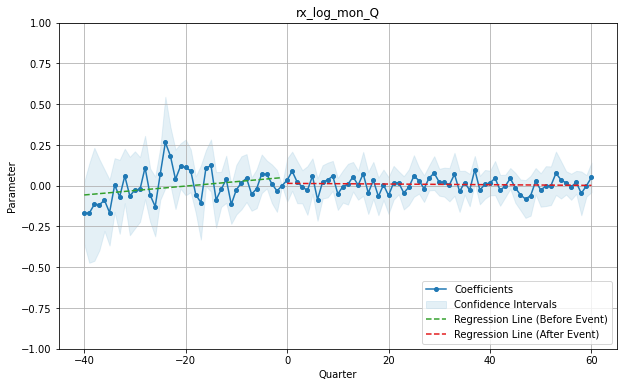

In [8]:
# take log
formula="log_rx_dom ~ "+elapsed


# log_stock_rx_lag
formula+=" + log_stock_rx_lag"
# ytrend
# formula+=ytrend
# months
# formula+=months
# generic_share_r
# formula+=" + generic_share_r"
# # generic_share_q
# formula+=" + generic_share_q"
formula+=" + log(generic_share_q)"

# fixed effects
formula+="+ TimeEffects+EntityEffects"
mod_fe=PanelOLS.from_formula(formula, data=df,drop_absorbed=True,check_rank=False)
res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)
print(res_fe.summary.tables[1])
print(res_fe.summary.tables[0])
plot_result(res_fe,file_name="rx_log_mon_Q",title="rx_log_mon_Q",period=before_p+after_p,insert_index=before_p-1,time_start=-before_p,markersize=4,xlabel="Quarter")

### OTC

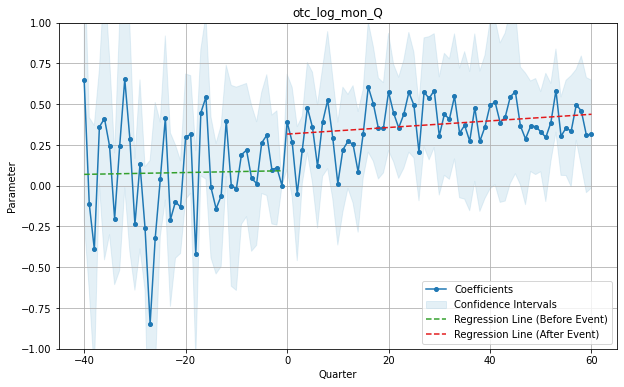

In [9]:
# take log

# till 20
# formula="log_otc_dom ~ elapsed_m5+elapsed_m4+elapsed_m3+elapsed_m2+elapsed_0+elapsed_1+elapsed_2+elapsed_3+elapsed_4+elapsed_5+elapsed_6+elapsed_7+elapsed_8+elapsed_9+elapsed_10+elapsed_11+elapsed_12+elapsed_13+elapsed_14+elapsed_15+elapsed_16+elapsed_17+elapsed_18+elapsed_19+elapsed_20+generic_per+TimeEffects+EntityEffects"

# take log
formula="log_otc_dom ~ "+elapsed


# log_stock_rx_lag
formula+=" + log_stock_otc_lag"
# ytrend
# formula+=ytrend
# months
# formula+=months
# generic_share_r
# formula+=" + generic_share_r"
# # generic_share_q
# formula+=" + generic_share_q"
formula+=" + log(generic_share_q)"


formula+="+ TimeEffects+EntityEffects"
mod_fe=PanelOLS.from_formula(formula, data=df,drop_absorbed=True)
res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)
# res_fe=mod_fe.fit()
# print(res_fe.summary.tables[1])
# print(res_fe.summary.tables[0])
# print(res_fe)
plot_result(res_fe,file_name="otc_log_mon_Q",title="otc_log_mon_Q",plot_type="-o",period=before_p+after_p,insert_index=before_p-1,time_start=-before_p,markersize=4,color_palette="Paired",xlabel="Quarter")